# CheXagent disease classification on [NIH Chest X-ray data](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


###### Imports


In [1]:
import io
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image
from rich import print
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    hamming_loss,
    jaccard_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
    classification_report,
)
from sklearn.preprocessing import MultiLabelBinarizer

sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

###### Function definitions


In [25]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(
        device=device, dtype=dtype
    )
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


def get_ypred(response, labels):
    return tuple(label for label in labels if label in response)


def get_tps(series):
    tps = [x for x in series["y_pred"] if x in series["y_true"]]
    return tuple(tps)


def get_fps(series):
    fps = [x for x in series["y_pred"] if x not in series["y_true"]]
    return tuple(fps)


def get_tns(series, labels):
    tns = [x for x in labels if (x not in series["y_true"]) and (x not in series["y_pred"])]
    return tuple(tns)


def get_fns(series):
    fns = [x for x in series["y_true"] if x not in series["y_pred"]]
    return tuple(fns)


def disp_df(dataframe):
    display(dataframe.head())
    print(f"nRows: {dataframe.shape[0]:,}\tnColumns: {dataframe.shape[1]}")


def compute_mlc_metrics_wide(df, labels):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mlb = MultiLabelBinarizer(classes=labels)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)

    # Multi-label averaging parameter options: "macro", "weighted", "micro", "samples", and None
    avg = None

    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics_wide = pd.DataFrame()
    for zero_div in [0.0, 1.0, np.nan]:

        # zero-div param for jaccard score cannot be NAN
        if isinstance(zero_div, float) and np.isnan(zero_div):
            zero_div_j = 0.0
        else:
            zero_div_j = zero_div
        index_label_zero_div = index_label_zero_div_map[zero_div]

        jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
        precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
        recall = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
        f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)

        df_i = pd.DataFrame(
            np.vstack([jaccard, precision, recall, f1]),
            columns=mlb.classes_.tolist(),
            index=["jaccard", "precision", "recall", "f1"],
        )
        df_i.index.name = "metric"
        df_i["zerodiv_opt"] = index_label_zero_div
        df_i = df_i.reset_index()
        df_i = df_i[["zerodiv_opt", "metric"] + mlb.classes_.tolist()]

        metrics_wide = pd.concat([metrics_wide, df_i], ignore_index=True)

    metrics_wide = metrics_wide.sort_values("metric").reset_index(drop=True)

    return metrics_wide


def compute_mlc_metrics(df, labels):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mlb = MultiLabelBinarizer(classes=labels)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)

    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics = pd.DataFrame(
        columns=["avg_opt", "zerodiv_opt", "accuracy", "hammingloss", "jaccard", "precision", "recall", "f1"]
    )

    idx = 0
    for avg in ["macro", "weighted", "micro", "samples"]:
        for zero_div in [0.0, 1.0, np.nan]:
            # set avg param index label
            if avg:
                index_label_avg = avg
            else:
                index_label_avg = "none"

            # zero-div param for jaccard score cannot be NAN
            if isinstance(zero_div, float) and np.isnan(zero_div):
                zero_div_j = 0.0
            else:
                zero_div_j = zero_div
            index_label_zero_div = index_label_zero_div_map[zero_div]

            accuracy = accuracy_score(ytrue, ypred)
            hammingloss = hamming_loss(ytrue, ypred)
            jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
            precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
            recall = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
            f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)

            metrics.loc[idx, :] = (
                index_label_avg,
                index_label_zero_div,
                accuracy,
                hammingloss,
                jaccard,
                precision,
                recall,
                f1,
            )
            idx += 1

    return metrics

## NIH Chest X-ray dataset


###### Load dataset


In [ ]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "./data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
display(data.head())
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
print(f"Number of patients: {data['patient_id'].nunique():,}")

###### Visualize data


In [ ]:
GOLDEN = (1 + 5**0.5) / 2
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")

plt.subplot(2, 3, 2)
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")

# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8
for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

plt.subplot(2, 3, 3)
sns.barplot(data.iloc[:, 11:-1].sum(axis=1).value_counts(), orient="h")
plt.gca().set(title="Number of findings per image", xlabel="Counts", ylabel="Number of findings")

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

plt.subplot(2, 3, 4)
sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)

plt.subplot(2, 3, 5)
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

###### remove calculated columns


In [ ]:
data = data[column_names]

## Analyze prompts and responses


###### import results


In [3]:
# filelist = [x.as_posix() for x in Path("output").rglob("disease_classification_QA*.csv")]
filelist = [x.as_posix() for x in Path("output").rglob("CheXagent_results_on_NIH_CXR.csv.gz")]
results = pd.DataFrame()
for f in filelist:
    df_i = pd.read_csv(f, usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str)
    results = pd.concat([results, df_i])

results = results.drop_duplicates(ignore_index=True)

In [5]:
labels = (
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax",
    # "No Finding",
)
# results["y_true"] = results["finding_labels"].str.split("|")
results["y_true"] = results["finding_labels"].apply(lambda x: tuple(x.replace("No Finding", "").split("|")))
results["y_pred"] = results["response"].apply(lambda x: get_ypred(x, labels))
results["n_labels"] = results["y_true"].apply(len)
results["response_num_findings"] = results["y_pred"].apply(len)

mlb = MultiLabelBinarizer(classes=labels)
ytrue = mlb.fit_transform(results["y_true"])
ypred = mlb.fit_transform(results["y_pred"])

results["true_positives"] = results.apply(get_tps, axis=1)
results["false_positives"] = results.apply(get_fps, axis=1)
results["true_negatives"] = results.apply(lambda x: get_tns(x, labels), axis=1)
results["false_negatives"] = results.apply(get_fns, axis=1)

disp_df(results)

/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


,image_index,finding_labels,prompt_key,response,y_true,y_pred,n_labels,response_num_findings,true_positives,false_positives,true_negatives,false_negatives
0,00007109_020.png,Fibrosis|Pneumonia,11,Atelectasis,"(Fibrosis, Pneumonia)","(Atelectasis,)",2,1,(),"(Atelectasis,)","(Cardiomegaly, Consolidation, Edema, Effusion,...","(Fibrosis, Pneumonia)"
1,00007109_020.png,Fibrosis|Pneumonia,12,"Atelectasis, Infiltration","(Fibrosis, Pneumonia)","(Atelectasis, Infiltration)",2,2,(),"(Atelectasis, Infiltration)","(Cardiomegaly, Consolidation, Edema, Effusion,...","(Fibrosis, Pneumonia)"
2,00007109_020.png,Fibrosis|Pneumonia,13,"A) 'Atelectasis', B) 'Cardiomegaly', C) 'Conso...","(Fibrosis, Pneumonia)","(Atelectasis, Cardiomegaly, Consolidation, Ede...",2,11,"(Fibrosis, Pneumonia)","(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Hernia, Mass, Pneumothorax)",()
3,00007109_020.png,Fibrosis|Pneumonia,14,"L) 'Pleural_Thickening', M) 'Pneumonia'","(Fibrosis, Pneumonia)","(Pleural_Thickening, Pneumonia)",2,2,"(Pneumonia,)","(Pleural_Thickening,)","(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Fibrosis,)"
4,00007109_020.png,Fibrosis|Pneumonia,15,I) 'Infiltration',"(Fibrosis, Pneumonia)","(Infiltration,)",2,1,(),"(Infiltration,)","(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Fibrosis, Pneumonia)"


nRows: 1,114,710        nColumns: 12

In [6]:
# make "prompt_key" categorical
prompt_file_list = Path("data").glob("prompts*")
prompts = {}
for prompt_file in prompt_file_list:
    with open(prompt_file.as_posix(), "r") as json_file:
        data = json.load(json_file)
        prompts.update(data)

prompt_key_order = [int(key) for key in prompts.keys()]
prompt_key_order.sort()
prompt_key_order = [str(key) for key in prompt_key_order]

results["prompt_key"] = pd.Categorical(results["prompt_key"], ordered=True, categories=prompt_key_order)

# make response_num_findings, and make categorical
# response_num_findings_order = results["response_num_findings"].drop_duplicates().sort_values().values
# results["response_num_findings"] = pd.Categorical(
#     results["response_num_findings"], ordered=True, categories=response_num_findings_order
# )

display(results.dtypes)

image_index                object
finding_labels             object
prompt_key               category
response                   object
y_true                     object
y_pred                     object
n_labels                    int64
response_num_findings       int64
true_positives             object
false_positives            object
true_negatives             object
false_negatives            object
dtype: object

###### analyze response strings


In [ ]:
# results["true_positives_len"] = results["true_positives"].transform(len)
# results["false_positives_len"] = results["false_positives"].transform(len)
# results["true_negatives_len"] = results["true_negatives"].transform(len)
# results["false_negatives_len"] = results["false_negatives"].transform(len)

# results["accuracy"] = (results["true_positives_len"] + results["true_negatives_len"]) / 15
# results["recall"] = results["true_positives_len"] / (results["true_positives_len"] + results["false_negatives_len"])
# results["precision"] = results["true_positives_len"] / (results["true_positives_len"] + results["false_positives_len"])
# results["f1"] = (2 * ((results["precision"] * results["recall"]) / (results["precision"] + results["recall"]))).fillna(
#     0.0
# )
# results["specificity"] = results["true_negatives_len"] / (
#     results["true_negatives_len"] + results["false_positives_len"]
# )

# disp_df(results)
# remove outlier case
# results = results.loc[results["response_num_findings"] != 0, :]

#### Evaluate MLC task of the different prompts

[Comprehensive comparative study of multi-label classification methods](https://doi.org/10.1016/j.eswa.2022.117215)

4.5 Statistical evaluation if performance of the methods are statisitically significant:

- corrected Friedman test (non-parametric multiple hypothesis test)
- post-hoc Nemenyi test


##### Findings: Three or more


###### Determine `scikit-learn` metric params


In [9]:
# load prompts used three or more findings
with open("data/prompts_three_or_more_findings.json", "r") as json_file:
    prompts = json.load(json_file)

# subset results
df_res = results[results["prompt_key"] == "1"].copy()

disp_df(df_res)

,image_index,finding_labels,prompt_key,response,y_true,y_pred,n_labels,response_num_findings,true_positives,false_positives,true_negatives,false_negatives
143060,00001582_019.png,Pneumonia,1,No Finding,"(Pneumonia,)",(),1,0,(),(),"(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Pneumonia,)"
143061,00001582_020.png,Effusion,1,No Finding,"(Effusion,)",(),1,0,(),(),"(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Effusion,)"
143062,00001582_021.png,Pneumonia,1,No Finding,"(Pneumonia,)",(),1,0,(),(),"(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Pneumonia,)"
143063,00001583_002.png,Emphysema,1,No Finding,"(Emphysema,)",(),1,0,(),(),"(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Emphysema,)"
143064,00001583_003.png,Pneumothorax,1,No Finding,"(Pneumothorax,)",(),1,0,(),(),"(Atelectasis, Cardiomegaly, Consolidation, Ede...","(Pneumothorax,)"


nRows: 91,324   nColumns: 12

In [10]:
# Isolate one particular label and analyze one binary case
true_0, pred_0 = ytrue[:, 0], ypred[:, 0]
temp = pd.DataFrame({"true": ytrue[:, 0], "pred": ypred[:, 0]})

temp["true_pos"] = 0.0
temp.loc[(temp["true"] == 1) & (temp["pred"] == 1), "true_pos"] = 1

temp["true_neg"] = 0.0
temp.loc[(temp["true"] == 0) & (temp["pred"] == 0), "true_neg"] = 1

temp["false_pos"] = 0.0
temp.loc[(temp["true"] == 0) & (temp["pred"] == 1), "false_pos"] = 1

temp["false_neg"] = 0.0
temp.loc[(temp["true"] == 1) & (temp["pred"] == 0), "false_neg"] = 1

disp_df(temp)

val_binary = recall_score(true_0, pred_0, average="binary", zero_division=0.0)
val_micro = recall_score(true_0, pred_0, average="micro", zero_division=0.0)
val_macro = recall_score(true_0, pred_0, average="macro", zero_division=0.0)
print(f"recall(avg='binary'): {val_binary}")
print(f"recall(avg='micro' or 'weighted'): {val_micro}")
print(f"recall(avg='macro'): {val_macro}")

# this matches average = "binary"
val = temp["true_pos"].sum() / (temp["true_pos"].sum() + temp["false_neg"].sum())
print(f"replicate metric for avg='binary': {val}")

# this matches average = "micro" or "weighted"
val = (temp["true_pos"].sum() + temp["true_neg"].sum()) / temp.shape[0]
print(f"replicate metric for avg='micro' or 'weighted': {val}")

# this matches average = "macro"
val = recall_score(true_0, pred_0, average=None, zero_division=0.0).mean()
print(f"replicate metric for avg='macro': {val}")

,true,pred,true_pos,true_neg,false_pos,false_neg
0,0,1,0.0,0.0,1.0,0.0
1,0,1,0.0,0.0,1.0,0.0
2,0,1,0.0,0.0,1.0,0.0
3,0,0,0.0,1.0,0.0,0.0
4,0,0,0.0,1.0,0.0,0.0


nRows: 1,114,710        nColumns: 6

recall(avg='binary'): 0.5254840546697038

recall(avg='micro' or 'weighted'): 0.6589301253240754

recall(avg='macro'): 0.5996882903271319

replicate metric for avg='binary': 0.5254840546697038

replicate metric for avg='micro' or 'weighted': 0.6589301253240754

replicate metric for avg='macro': 0.5996882903271319

In [21]:
metrics_wide = compute_mlc_metrics_wide(df_res, labels)
metrics = compute_mlc_metrics(df_res, labels)
display(metrics_wide)
display(metrics)

/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


,zerodiv_opt,metric,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.0,0.0,0.0,0.016751,0.032200,0.002199,0.0,0.015000,0.006352
1,1,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.0,0.0,0.0,0.016751,0.032200,0.002199,0.0,0.015000,0.006352
2,nan,f1,0.021153,0.056526,0.086778,0.011753,0.112694,0.0,0.0,0.0,0.016751,0.032200,0.002199,0.0,0.015000,0.006352
3,0,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.0,0.0,0.0,0.008446,0.016364,0.001101,0.0,0.007557,0.003186
4,1,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.0,0.0,0.0,0.008446,0.016364,0.001101,0.0,0.007557,0.003186
5,nan,jaccard,0.010690,0.029085,0.045357,0.005911,0.059711,0.0,0.0,0.0,0.008446,0.016364,0.001101,0.0,0.007557,0.003186
6,0,precision,0.066583,0.064478,0.078541,0.015267,0.328449,0.0,0.0,0.0,0.174274,0.371134,0.130435,0.0,0.038462,0.700000
7,1,precision,0.066583,0.064478,0.078541,0.015267,0.328449,0.0,0.0,1.0,0.174274,0.371134,0.130435,0.0,0.038462,0.700000
8,nan,precision,0.066583,0.064478,0.078541,0.015267,0.328449,0.0,0.0,NaN,0.174274,0.371134,0.130435,0.0,0.038462,0.700000
9,0,recall,0.012574,0.050320,0.096947,0.009554,0.068015,0.0,0.0,0.0,0.008799,0.016830,0.001109,0.0,0.009317,0.003191


,avg_opt,zerodiv_opt,accuracy,hammingloss,jaccard,precision,recall,f1
0,macro,0,0.654253,0.027277,0.013386,0.140544,0.019761,0.025815
1,macro,1,0.654253,0.027277,0.013386,0.211973,0.019761,0.025815
2,macro,nan,0.654253,0.027277,0.013386,0.151356,0.019761,0.025815
3,weighted,0,0.654253,0.027277,0.016283,0.197696,0.020767,0.031367
4,weighted,1,0.654253,0.027277,0.016283,0.201249,0.020767,0.031367
5,weighted,nan,0.654253,0.027277,0.016283,0.198401,0.020767,0.031367
6,micro,0,0.654253,0.027277,0.018103,0.123701,0.020767,0.035563
7,micro,1,0.654253,0.027277,0.018103,0.123701,0.020767,0.035563
8,micro,nan,0.654253,0.027277,0.018103,0.123701,0.020767,0.035563
9,samples,0,0.654253,0.027277,0.00272,0.00272,0.007041,0.00358


In [24]:
prompt_keys = results["prompt_key"].unique()

df_agg_wide = pd.DataFrame()
df_agg = pd.DataFrame()
for prompt_key in prompt_keys:
    df_input = results[results["prompt_key"] == prompt_key].copy()

    metrics_wide_i = compute_mlc_metrics_wide(df_input, labels)
    metrics_wide_i["prompt_key"] = prompt_key
    df_agg_wide = pd.concat([df_agg_wide, metrics_wide_i], ignore_index=True)

    metrics_i = compute_mlc_metrics(df_input, labels)
    metrics_i["prompt_key"] = prompt_key
    df_agg = pd.concat([df_agg, metrics_i], ignore_index=True)

display(df_agg_wide)
display(df_agg)

/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/home/mark/miniforge3/envs/chexagent/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [''] w

,zerodiv_opt,metric,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,prompt_key
0,0,f1,0.446775,0.315032,0.272545,0.234523,0.358946,0.133739,0.024883,0.000000,0.560616,0.080329,0.063113,0.228498,0.009677,0.189434,11
1,1,f1,0.446775,0.315032,0.272545,0.234523,0.358946,0.133739,0.024883,0.000000,0.560616,0.080329,0.063113,0.228498,0.009677,0.189434,11
2,nan,f1,0.446775,0.315032,0.272545,0.234523,0.358946,0.133739,0.024883,0.000000,0.560616,0.080329,0.063113,0.228498,0.009677,0.189434,11
3,0,jaccard,0.287643,0.186966,0.157772,0.132838,0.218729,0.071661,0.012598,0.000000,0.389483,0.041845,0.032585,0.128986,0.004862,0.104627,11
4,1,jaccard,0.287643,0.186966,0.157772,0.132838,0.218729,0.071661,0.012598,0.000000,0.389483,0.041845,0.032585,0.128986,0.004862,0.104627,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1,precision,0.730539,0.769231,0.389535,0.406433,0.863572,0.471545,0.251656,1.000000,0.775701,1.000000,1.000000,0.247649,0.162121,0.788462,30
344,nan,precision,0.730539,0.769231,0.389535,0.406433,0.863572,0.471545,0.251656,1.000000,0.775701,1.000000,1.000000,0.247649,0.162121,0.788462,30
345,0,recall,0.114161,0.122283,0.040954,0.348808,0.448904,0.078804,0.104110,0.022727,0.041212,0.002465,0.000724,0.351111,0.189381,0.094761,30
346,1,recall,0.114161,0.122283,0.040954,0.348808,0.448904,0.078804,0.104110,0.022727,0.041212,0.002465,0.000724,0.351111,0.189381,0.094761,30


,avg_opt,zerodiv_opt,accuracy,hammingloss,jaccard,precision,recall,f1,prompt_key
0,macro,0,0.024186,0.187569,0.126471,0.367547,0.260433,0.208436,11
1,macro,1,0.024186,0.187569,0.126471,0.438976,0.260433,0.208436,11
2,macro,nan,0.024186,0.187569,0.126471,0.39582,0.260433,0.208436,11
3,weighted,0,0.024186,0.187569,0.207717,0.496286,0.348385,0.325461,11
4,weighted,1,0.024186,0.187569,0.207717,0.498837,0.348385,0.325461,11
...,...,...,...,...,...,...,...,...,...
343,micro,1,0.0,0.231752,0.143119,0.541911,0.162817,0.2504,30
344,micro,nan,0.0,0.231752,0.143119,0.541911,0.162817,0.2504,30
345,samples,0,0.0,0.231752,0.165318,0.541911,0.165318,0.252188,30
346,samples,1,0.0,0.231752,0.165318,0.541911,0.165318,0.252188,30


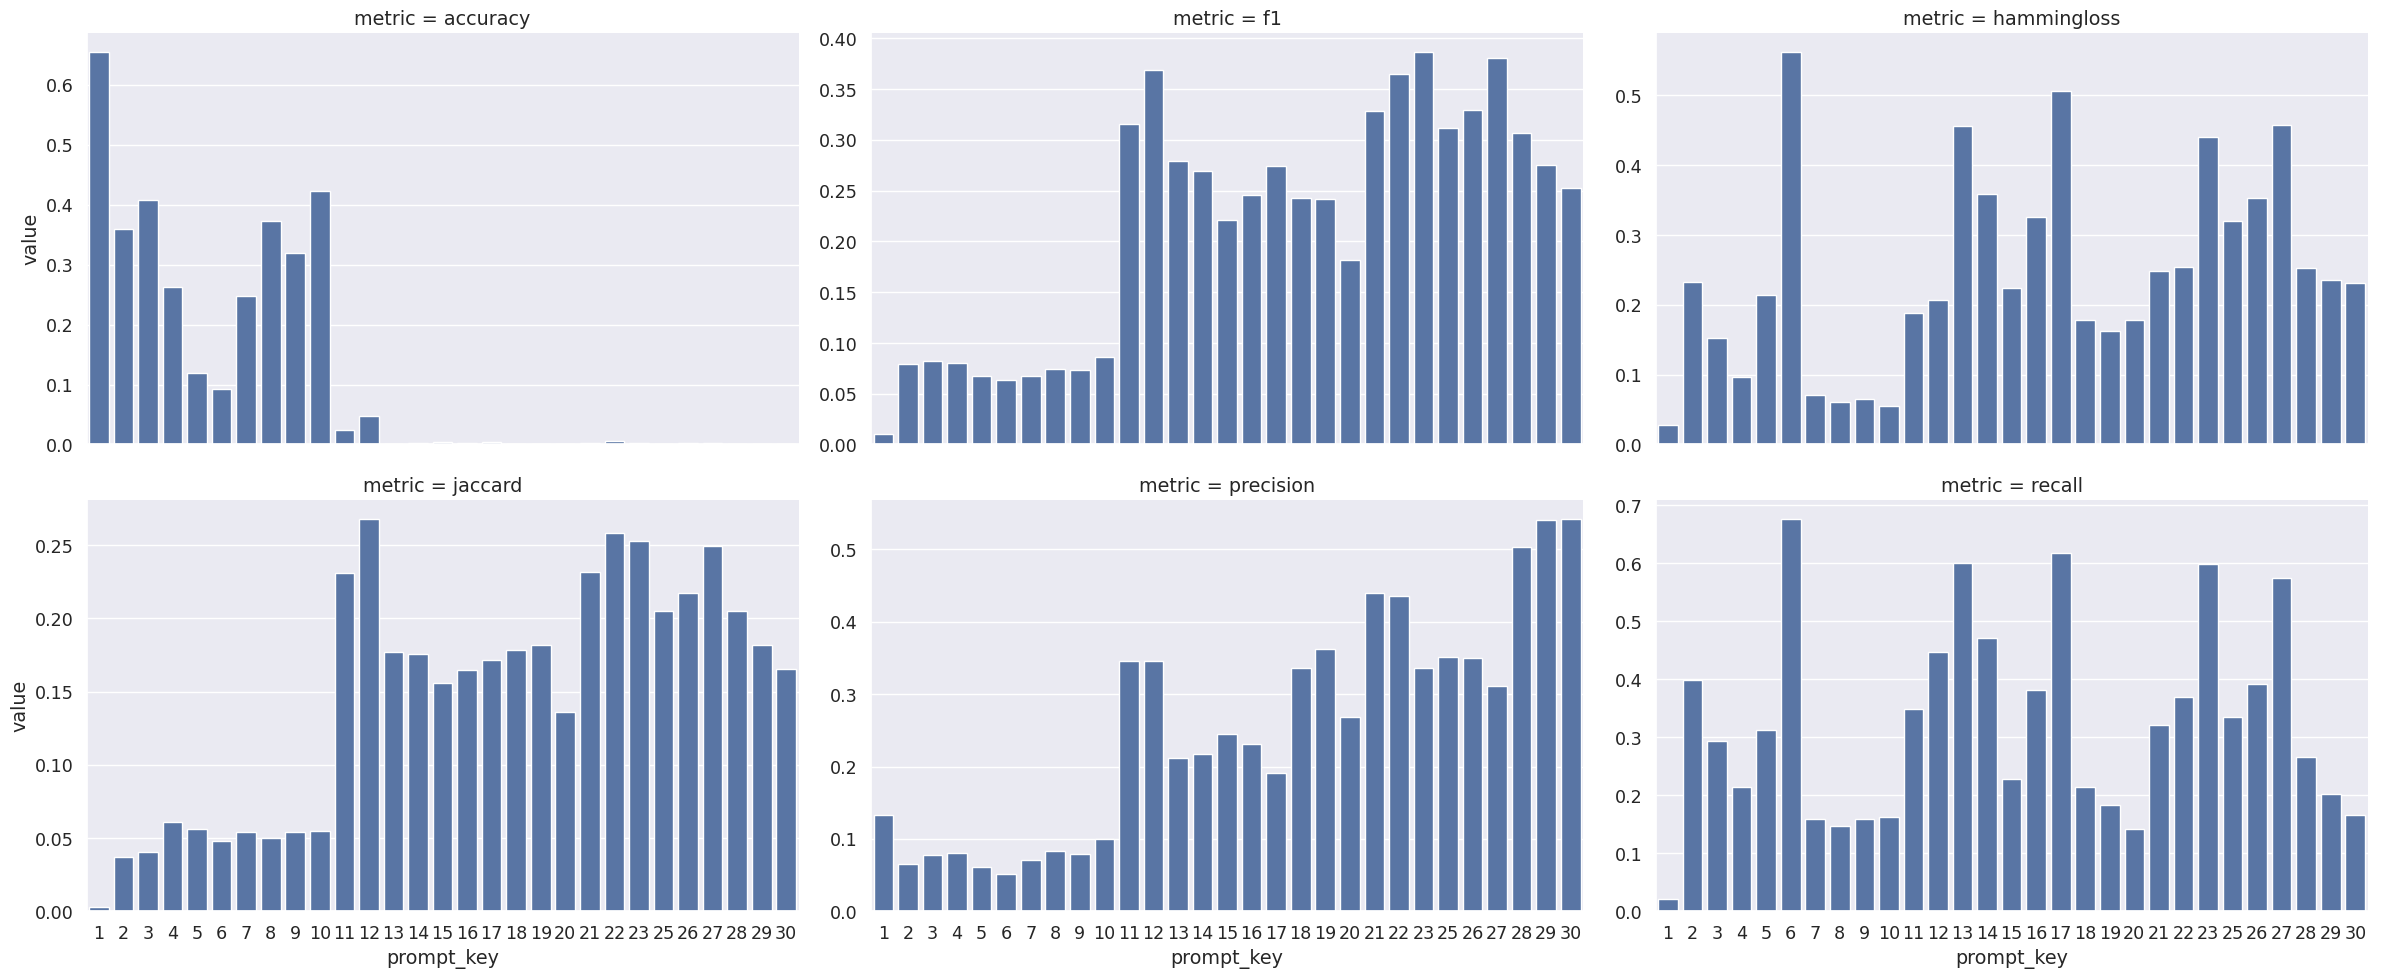

In [85]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

plotdf = (
    df_agg.loc[df_agg["zerodiv_opt"] == "nan"]
    .loc[df_agg["avg_opt"] == "samples"]
    # .loc[df_agg["prompt_key"].astype(int).isin(np.arange(1, 11))]
    .drop(columns=["avg_opt", "zerodiv_opt"])
    .melt(id_vars=["prompt_key"], var_name="metric")
)
plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
plotdf = plotdf.sort_values(["metric", "prompt_key"], ignore_index=True)

g = sns.catplot(data=plotdf, x="prompt_key", y="value", col="metric", col_wrap=3, kind="bar", sharey=False, aspect=1.602)

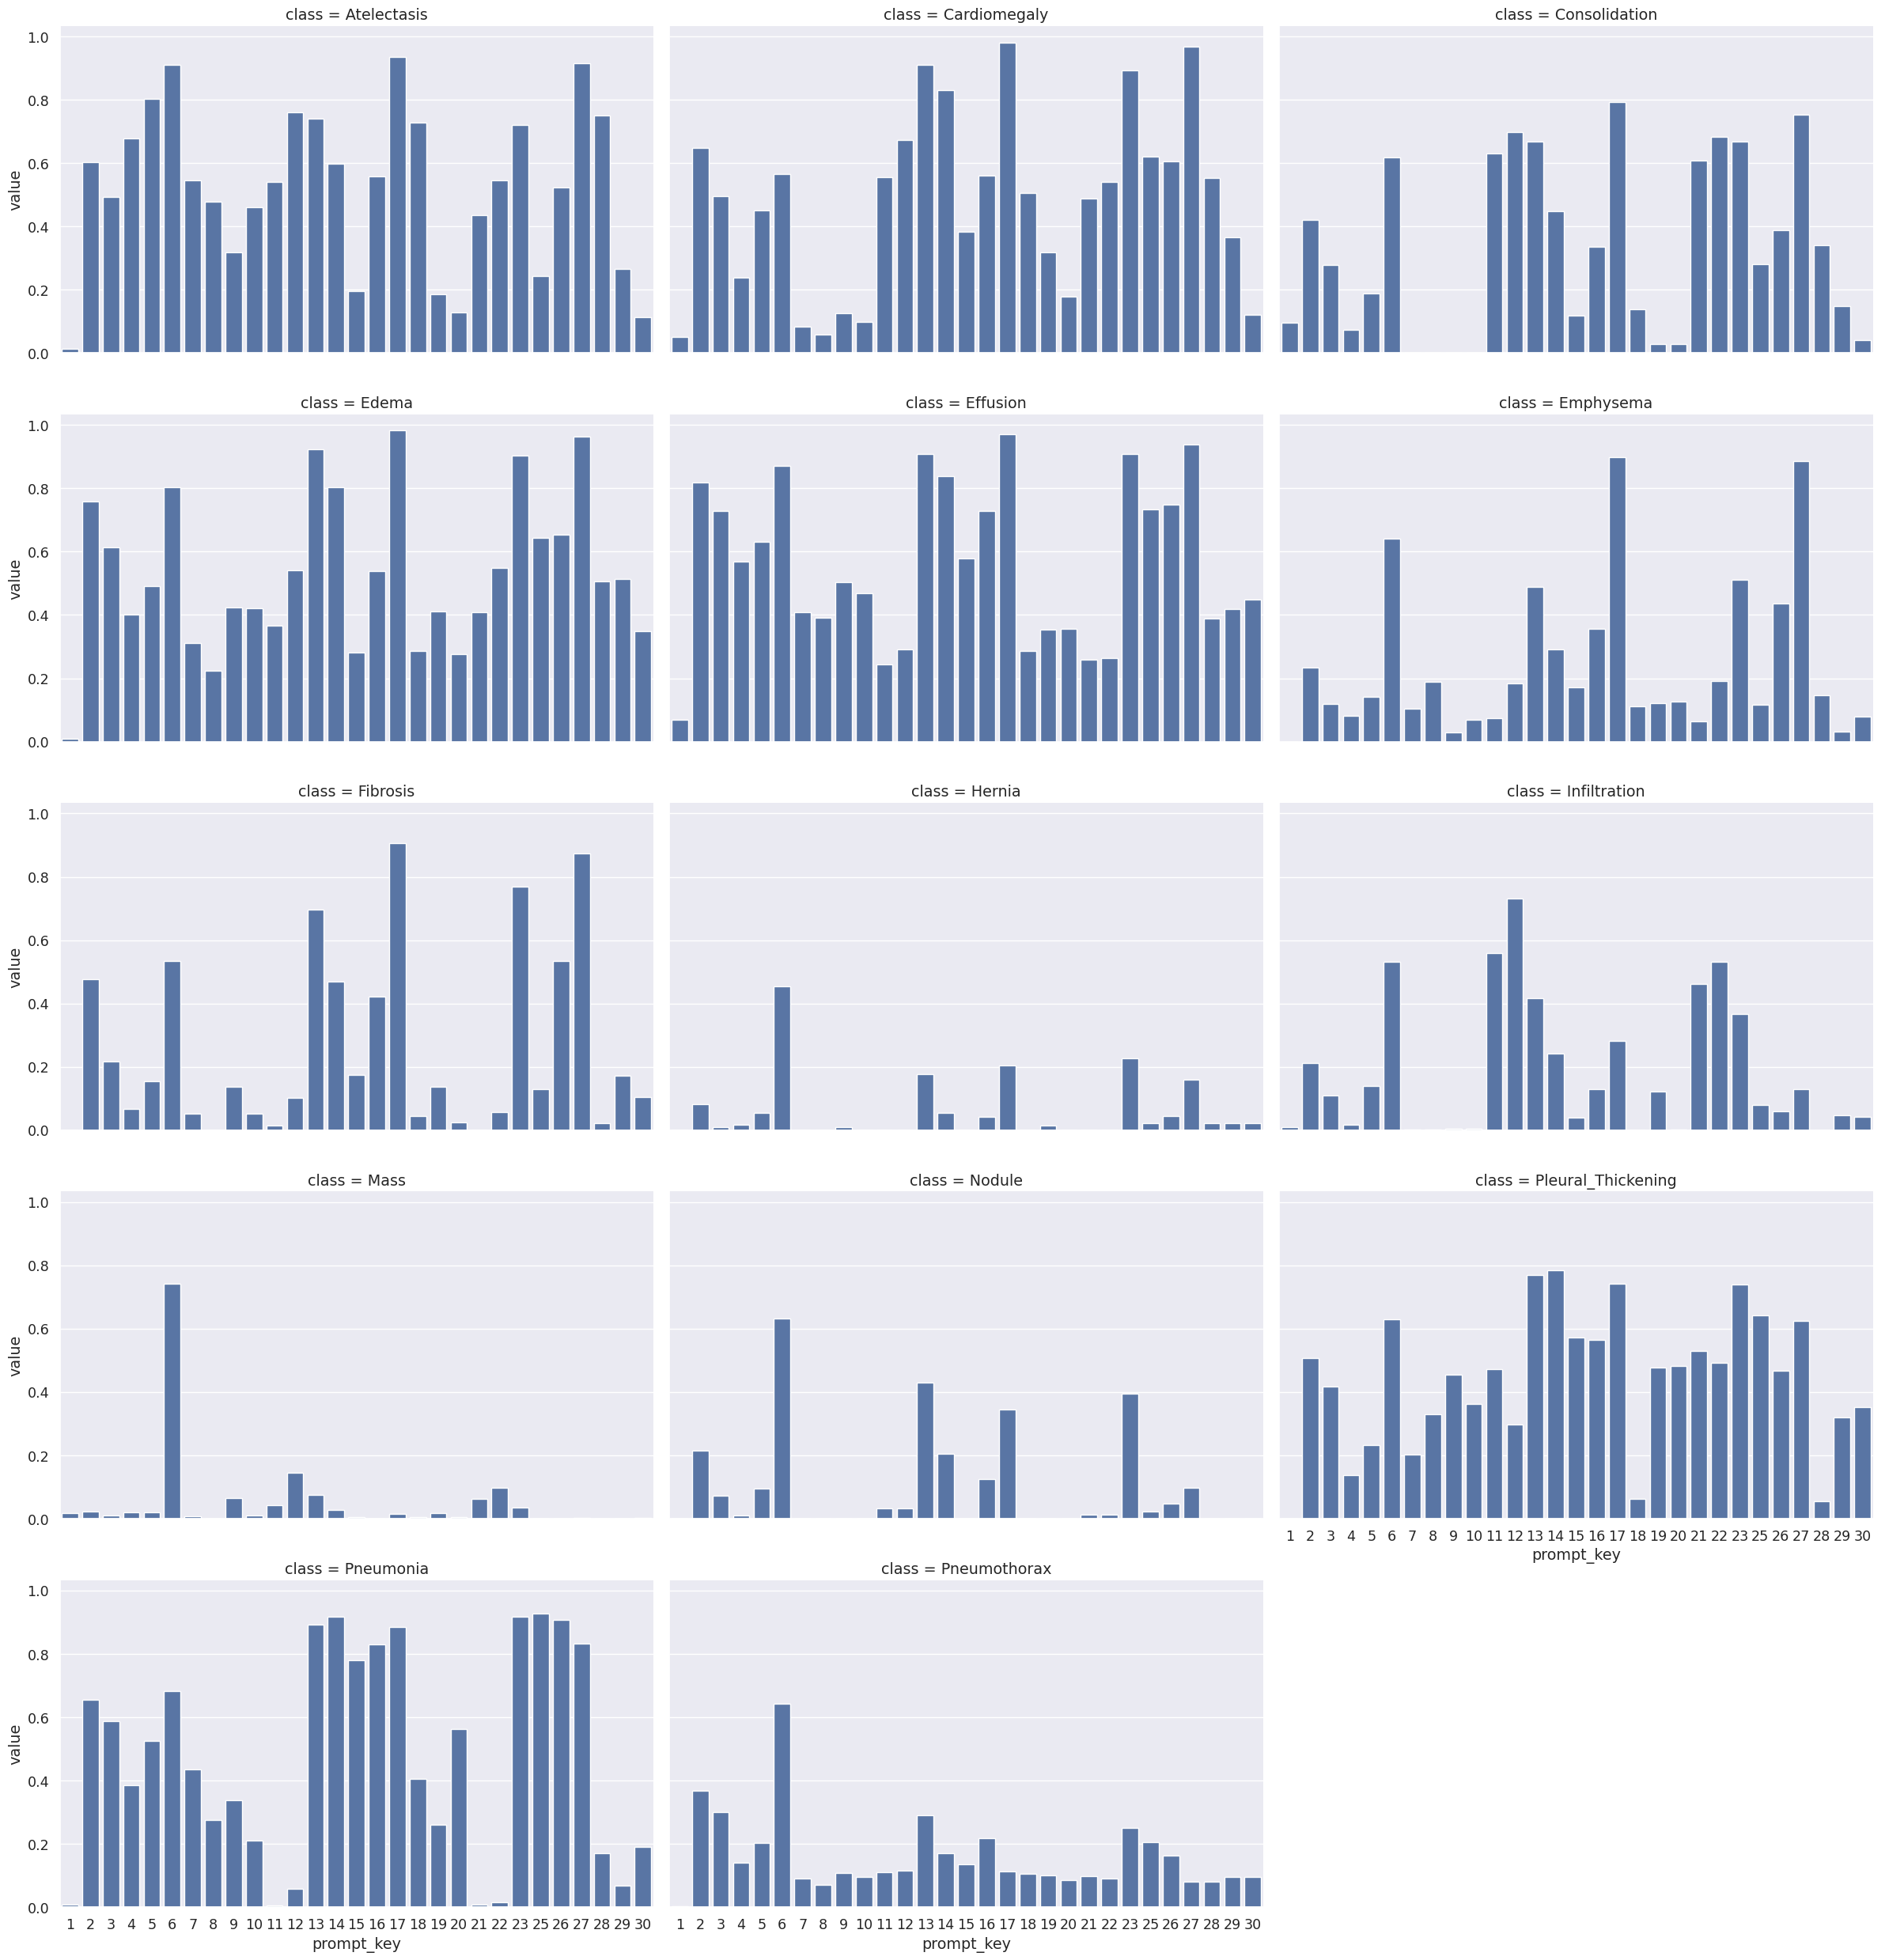

In [86]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "recall"]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(1, 11))]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(11, 21))]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(21, 31))]
    .drop(columns=["zerodiv_opt"])
    .melt(id_vars=["metric", "prompt_key"], var_name="class")
)
plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
plotdf = plotdf.sort_values(["prompt_key", "class", "metric"], ignore_index=True)
g = sns.catplot(data=plotdf, x="prompt_key", y="value", col="class", col_wrap=3, kind="bar", sharey=True, aspect=1.602)

In [ ]:
# Compute confusion matrices for each class
mcm = multilabel_confusion_matrix(ytrue, ypred)


# Function to plot confusion matrices for each class
def plot_multilabel_confusion_matrix(mcm, classes):
    fig, axes = plt.subplots(
        nrows=int(len(classes) / 2) + len(classes) % 2, ncols=2, figsize=(10, 4 * int(len(classes) / 2))
    )
    for i, (cm, class_name) in enumerate(zip(mcm, classes)):
        ax = axes.flatten()[i]
        sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(f"Class: {class_name}")
        ax.xaxis.set_ticklabels(["Negative", "Positive"])
        ax.yaxis.set_ticklabels(["Negative", "Positive"])

    plt.tight_layout()
    plt.show()


# Plotting the confusion matrices
plot_multilabel_confusion_matrix(mcm, mlb.classes_)

#### Plots


##### Confusion matrix


In [ ]:
conf_matrices = {label: {"TP": 0, "FP": 0, "TN": 0, "FN": 0} for label in classes}


def update_conf_matrix(row, label):
    if label in row["true_positives"]:
        conf_matrices[label]["TP"] += 1
    if label in row["false_positives"]:
        conf_matrices[label]["FP"] += 1
    if label in row["true_negatives"]:
        conf_matrices[label]["TN"] += 1
    if label in row["false_negatives"]:
        conf_matrices[label]["FN"] += 1


for label in classes:
    results.apply(lambda row: update_conf_matrix(row, label), axis=1)


conf_matrices

In [ ]:
sns.set_theme(style="white")

for label, matrix in conf_matrices.items():
    cm = np.array([[matrix["TP"], matrix["FP"]], [matrix["FN"], matrix["TN"]]])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

##### Histogram on `response_num_findings`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="prompt_key",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="prompt_key",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Share of no. of findings within generated response by prompt")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="finding_labels",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Share of no. of findings within generated response by GT label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    # palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    palette="tab20",
)

g.set_axis_labels(x_var="Resp. number of findings")
g.legend.set_title("Finding")
g.tight_layout()
plt.show()

##### Histogram on `prompt_key`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Is label in generated response?")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Share of generated responses with correct label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="response_num_findings",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(0.85, 0.5), title="No. labels\nin response")
g.figure.suptitle("Share of number of findings within generated response by prompt")
g.tight_layout()
plt.show()

##### Heatmaps


In [ ]:
sns.set_theme(style="white")

plotdf = (
    results.groupby(["prompt_key", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="prompt_key", index="response_num_findings", values=0)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".0f")
ax.set(title="Number of findings in response by prompt", xlabel="Prompt Key", ylabel="Number of findings in response")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="white", font_scale=1)

plotdf = (
    results.groupby(["finding_labels", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="finding_labels", index="response_num_findings", values=0)
    .transform(lambda x: (x / x.sum()) * 100)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 8, 8))
ax = sns.heatmap(plotdf, annot=True, fmt=".1f")
ax.set(
    title="Number of findings in response by disease\n(values are percentages, columns sum to 100%)",
    xlabel="Disease",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Multi-finding imags


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.relplot(
    data=results,
    x="response_num_findings",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

## Getting started with `scikit-multilearn`


In [ ]:
from skmultilearn.dataset import load_dataset

In [ ]:
X_train, y_train, feature_names, label_names = load_dataset("emotions", "train")
X_test, y_test, _, _ = load_dataset("emotions", "test")

In [ ]:
feature_names[:10]

In [ ]:
label_names

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

In [ ]:
clf = BinaryRelevance(classifier=SVC(), require_dense=[False, True])

In [ ]:
clf.classifiers

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.classifiers

In [ ]:
prediction = clf.predict(X_test)

In [ ]:
prediction

### Measure the quality


In [ ]:
import sklearn.metrics as metrics

In [ ]:
metrics.hamming_loss(y_test, prediction)

In [ ]:
metrics.accuracy_score(y_test, prediction)